### 1. Importing Module

In [14]:
# Import module yang dibutuhkan

import os, re, json
import pandas as pd
import matplotlib.pyplot as plt, seaborn as sns, numpy as np
import catboost
import warnings; warnings.simplefilter('ignore')
import shap, graphviz
import sklearn
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from imblearn.over_sampling import SMOTENC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from catboost import CatBoostClassifier, Pool, cv
from catboost import MetricVisualizer
from catboost.eval.catboost_evaluation import *
from catboost import *
from catboost import datasets
from catboost.utils import create_cd, quantize, get_roc_curve, get_fpr_curve, get_fnr_curve,select_threshold
%matplotlib inline 
plt.style.use('bmh'); sns.set()

print('Imported Module')

Imported Module


### 2. Loading Dataset

Dataset yang digunakan dalam penelitian ini adalah dataset yang telah tersedia di https://github.com/fcakyon/instafake-dataset. Dataset tersebut terdiri atas dua buah set yang masing-masing berupa file json, yaitu fake account dan automated account.

Dataset fake account dikumpulkan dari akun instagram dari berbagai negara yang kemudian dilabeli secara manual sehingga terkumpul sebanyak 994 akun real dan 200 akun palsu. Informasi yang tersedia dalam dataset tersebut adalah jumlah follower, jumlah following, jumlah posting-an, akun memiliki foto profil atau tidak, bersifat private atau tidak, jumlah karakter pada biografi akun, jumlah karakter pada username, dan jumlah digit pada username. Dataset ini nantinya akan digunakan dalam mendeteksi fake follower.

In [15]:
# Membuat dataframe FakeReal Account

# Buka file json 
with open("FakeReal.json", "r") as file:
    data = json.load(file)
        
dataframe = pd.DataFrame()

for i in data:
    user_follower_count = i["userFollowerCount"]
    user_following_count = i["userFollowingCount"]
    follower_following_ratio = user_follower_count/max(1,user_following_count)
            
    temp_dataframe = pd.Series({"user_media_count":i["userMediaCount"],
                                "user_follower_count":i["userFollowerCount"],
                                "user_following_count":i["userFollowingCount"],
                                "user_has_profil_pic":i["userHasProfilPic"],
                                "user_is_private":i["userIsPrivate"],
                                "follower_following_ratio":follower_following_ratio,
                                "user_biography_length":i["userBiographyLength"],
                                "username_length":i["usernameLength"],
                                "username_digit_count":i["usernameDigitCount"],
                                "is_fake":i["isFake"]
                                })
    
    dataframe = dataframe.append(temp_dataframe, ignore_index=True)

dataframe[['user_has_profil_pic', 'user_is_private', 'is_fake']] = dataframe[['user_has_profil_pic','user_is_private','is_fake']].astype('int32')
dataframe=dataframe[['is_fake','follower_following_ratio','user_biography_length','user_follower_count','user_following_count','user_has_profil_pic','user_is_private','user_media_count','username_digit_count','username_length']]

cols = list(dataframe.columns.values)
print("jumlah data :", len(dataframe))

jumlah data : 1194


In [3]:
# Menampilkan lima data pertama
dataframe.head()

is_fake  follower_following_ratio  user_biography_length  \
0        1                  0.012907                    0.0   
1        1                  0.078603                    0.0   
2        1                  0.037594                    0.0   
3        1                  0.130841                    0.0   
4        1                  0.056762                    0.0   

   user_follower_count  user_following_count  user_has_profil_pic  \
0                 25.0                1937.0                    1   
1                324.0                4122.0                    1   
2                 15.0                 399.0                    0   
3                 14.0                 107.0                    1   
4                264.0                4651.0                    1   

   user_is_private  user_media_count  username_digit_count  username_length  
0                1               0.0                   0.0             10.0  
1                0               0.0                   4.0             15.0  
2                0               0.0                   3.0             12.0  
3                0               1.0                   1.0             10.0  
4                0               0.0                   0.0             14.0

In [4]:
# Melihat Ukuran Data
N, P = dataframe.shape
print('baris = ', N, ', Kolom = ', P)

dataframe.info()

baris =  1194 , Kolom =  10
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194 entries, 0 to 1193
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   is_fake                   1194 non-null   int32  
 1   follower_following_ratio  1194 non-null   float64
 2   user_biography_length     1194 non-null   float64
 3   user_follower_count       1194 non-null   float64
 4   user_following_count      1194 non-null   float64
 5   user_has_profil_pic       1194 non-null   int32  
 6   user_is_private           1194 non-null   int32  
 7   user_media_count          1194 non-null   float64
 8   username_digit_count      1194 non-null   float64
 9   username_length           1194 non-null   float64
dtypes: float64(7), int32(3)
memory usage: 79.4 KB


In [5]:
# Mencetak Nama Kolom
print(dataframe.columns.values)  

['is_fake' 'follower_following_ratio' 'user_biography_length'
 'user_follower_count' 'user_following_count' 'user_has_profil_pic'
 'user_is_private' 'user_media_count' 'username_digit_count'
 'username_length']


Dari info diatas dapat diketahui bahwa dataset memuat 10 variabel, yaitu
1. follower_following_ratio : Perbandingan jumlah follower dengan jumlah following dari setiap akun
2. is_fake : Apakah akun merupakan akun palsu (Bernilai Benar = 1) atau akun asli (Bernilai salah = 0)
3. user_biography_length : Jumlah karakter dalam biografi akun
4. user_follower_count : Jumlah follower dalam setiap akun
5. user_following_count : Jumlah following dalam setiap akun
6. user_has_profil_pic : Apakah akun memiliki foto profil atau tidak
7. user_is_private : Apakah akun bersifat private atau tidak
8. user_media_count : Jumlah postingan yang terdapat dalam setiap akun
9. username_digit_count : Jumlah digit pada username
10. username_length : Jumlah karakter pada username

### 3. Feature Preparation

In [10]:
# Mengecek Missing Values
print(dataframe.isnull().sum())

is_fake                     0
follower_following_ratio    0
user_biography_length       0
user_follower_count         0
user_following_count        0
user_has_profil_pic         0
user_is_private             0
user_media_count            0
username_digit_count        0
username_length             0
dtype: int64


Dari output diatas terlihat bahwa tidak terdapat missing value pada setiap variabelnya.

In [3]:
# Deklarasi fitur kategorik
# Menunjukkan kolom kategorik (ditentukan sebagai bilang bulat) atau name (ditentukan sebagai string). 
# Jika tidak ditentukan di awal, maka semua fitur dianggap numerik atau jenis lain jika ditentukan secara tepat

cat_features = ['user_has_profil_pic', 'user_is_private']
cat_features

['user_has_profil_pic', 'user_is_private']

In [4]:
# Memisahkan fitur(x) dan label(y)
X = dataframe.drop('is_fake', axis = 1)
Y = dataframe.is_fake

In [5]:
# Jika akan melatih sebuah model, maka kita harus dapat mendeteksi overfitting dan memilih parameter terbaik. 
# Untuk melakukan hal itu kita perlu memiliki dataset validasi.

x_train, x_validation, y_train, y_validation = train_test_split(X, Y, train_size=0.8, random_state=42)

# Pool Class digunakan sebagai dataset di CatBoost yang menyimpan semua informasi tentang dataset 
# (fitur, label, indeks fitur kategorik, bobot).
# Sama halnya seperti menggunakan numpy array atau dataframe.
# Akan tetapi menggunakan Pool Class adalah cara paling efisien dalam hal memori dan kecepatan.  

train_pool = Pool(data=x_train, label=y_train, cat_features=cat_features)
validation_pool = Pool(data=x_validation, label=y_validation, cat_features=cat_features)

print("{:<20}{}".format("Train size:", x_train.shape[0]))
print("{:<20}{}".format("Validation size:", x_validation.shape[0]))

Train size:         955
Validation size:    239


In [63]:
# Dataset Quantization
# Kuantisasi fitur yaitu mengukur fitur satu kali sebelum beberapa pelatihan akan efektif.

train_pool.quantize(
    border_count=254,
    # per_float_feature_quantization=['0:border_count=1024']
)

train_pool.save_quantization_borders('borders.tsv')

validation_pool.quantize(input_borders='borders.tsv')

### 4. Oversampling Data dengan SMOTE-NC

Fake Account 200
Real Account 994


Text(0.5, 1, 'Class Counts')

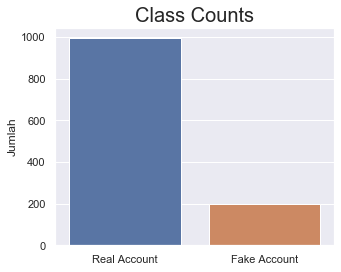

In [54]:
# Menampilkan jumlah masing-masing kelas

fake = dataframe[dataframe["is_fake"] == 1].shape[0]
real = dataframe[dataframe["is_fake"] == 0].shape[0]
print("Fake Account", fake)
print("Real Account", real) 
plt.figure(figsize=(5, 4))
sns.countplot(dataframe["is_fake"])
plt.xticks((0, 1), ["Real Account", "Fake Account"])
plt.xlabel("")
plt.ylabel("Jumlah")
plt.title("Class Counts", y=1, fontdict={"fontsize": 20})

Kedua kelas tidak seimbang. Dimana terdapat 994 akun nyata dan 200 akun palsu.

In [55]:
print('Total Data Train: {}'.format(x_train.shape[0]), 'dengan Jumlah Real Account {}'.format(sum(y_train==0)), 'dan Jumlah Fake Account {}'.format(sum(y_train==1)))

Total Data Train: 955 dengan Jumlah Real Account 794 dan Jumlah Fake Account 161


In [6]:
# Oversampling SMOTE-NC

ovr = SMOTENC(random_state=42, categorical_features=[0,5,6])
x_over, y_over = ovr.fit_resample(x_train, y_train.ravel())

In [7]:
x_table_smotenc = pd.DataFrame(x_over)
y_table_smotenc = pd.DataFrame(y_over)
balanced = pd.concat([y_table_smotenc, x_table_smotenc], axis=1)
balanced = pd.DataFrame(balanced)

balanced.columns = [
    'is_fake',
    'follower_following_ratio',
    'user_biography_length',
    'user_follower_count',
    'user_following_count',
    'user_has_profil_pic',
    'user_is_private',
    'user_media_count',
    'username_digit_count',
    'username_length'
]

Fake Account 794
Real Account 794


Text(0.5, 1, 'Class Counts')

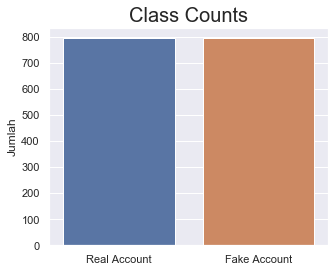

In [8]:
# Menampilkan jumlah masing-masing kelas

fake = balanced[balanced["is_fake"] == 1].shape[0]
real = balanced[balanced["is_fake"] == 0].shape[0]
print("Fake Account", fake)
print("Real Account", real)
plt.figure(figsize=(5, 4))
sns.countplot(balanced["is_fake"])
plt.xticks((0, 1), ["Real Account", "Fake Account"])
plt.xlabel("")
plt.ylabel("Jumlah")
plt.title("Class Counts", y=1, fontdict={"fontsize": 20})

In [11]:
print('Total Data Train: {}'.format(x_over.shape[0]), 'dengan Jumlah Real Account {}'.format(sum(y_over==0)), 'dan Jumlah Fake Account {}'.format(sum(y_over==1)))

Total Data Train: 1588 dengan Jumlah Real Account 794 dan Jumlah Fake Account 794


In [24]:
balanced.head()

is_fake  follower_following_ratio  user_biography_length  \
0        0                  1.003096                    0.0   
1        0                  0.545643                   30.0   
2        0                  0.899471                   27.0   
3        0                  0.787234                   53.0   
4        0                  0.894334                   34.0   

   user_follower_count  user_following_count  user_has_profil_pic  \
0                324.0                 323.0                    1   
1                263.0                 482.0                    1   
2                340.0                 378.0                    1   
3                740.0                 940.0                    1   
4                584.0                 653.0                    1   

   user_is_private  user_media_count  username_digit_count  username_length  
0                1             114.0                   0.0             10.0  
1                1              29.0                   0.0              8.0  
2                1               9.0                   0.0             12.0  
3                1             483.0                   0.0              9.0  
4                1              88.0                   0.0              9.0

In [8]:
balanced.shape

(1588, 10)

### 5. Data Visualization

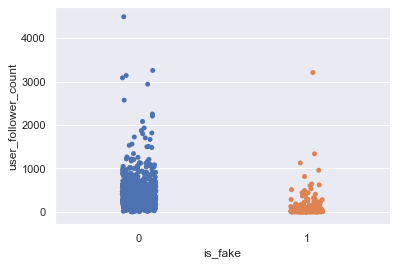

In [9]:
# Plot jumlah follower

p = sns.stripplot(x=dataframe['is_fake'], y=dataframe['user_follower_count'])

Dari scatterplot di atas terlihat bahwa sebagian besar akun fake memiliki jumlah follower yang sedikit, yaitu kurang dari 500 follower.  Sedangkan akun real memiliki jumlah follower yang lebih banyak, hingga ada yang berjumlah 3000 follower.

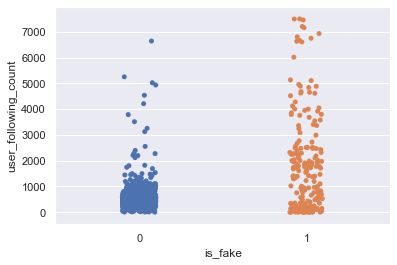

In [13]:
# Plot jumlah following

p = sns.stripplot(x=dataframe['is_fake'], y=dataframe['user_following_count'])

Dari scatterplot di atas terlihat bahwa akun fake memiliki following dengan jumlah yang besar yaitu berjumlah ribuan hingga mencapai 7000. Sebaliknya, sebagian besar akun asli memiliki following yang lebih sedikit yaitu kurang dari 1000.

In [10]:
# Melihat rata-rata akun yang merupakan fake atau real berdasarkan kepemilikan foto profil

dataframe[['user_has_profil_pic', 'is_fake']].groupby(['user_has_profil_pic'], as_index =False).mean().sort_values(by='is_fake', ascending = False)

user_has_profil_pic   is_fake
0                    0  0.858696
1                    1  0.109800

Rata-rata akun fake tanpa foto profil jauh lebih besar dibandingkan dengan akun fake yang memiliki foto profil, artinya berdasarkan data yang kita punya sebagian besar akun fake tidak memiliki foto profil.

In [11]:
# Melihat jumlah akun yang merupakan fake atau real berdasarkan akun tersebut disembunyikan (privat) atau tidak

dataframe[['user_is_private', 'is_fake']].groupby(['user_is_private'], as_index =False).sum().sort_values(by='is_fake', ascending = False)

user_is_private  is_fake
0                0      135
1                1       65

Jumlah akun fake yang tidak disembunyikan (privat) lebih banyak dibandingkan dengan akun fake yang disembunyikan, artinya berdasarkan data yang kita punya sebagian besar akun fake tidak disembunyikan.

In [12]:
dataframe.groupby(['is_fake']).mean()

follower_following_ratio  user_biography_length  user_follower_count  \
is_fake                                                                         
0                        0.942563              25.034205           419.891348   
1                        0.164261              11.980000           116.640000   

         user_following_count  user_has_profil_pic  user_is_private  \
is_fake                                                               
0                  516.138833             0.986922         0.724346   
1                 1878.030000             0.605000         0.325000   

         user_media_count  username_digit_count  username_length  
is_fake                                                           
0               68.473843                0.2666        11.070423  
1                3.535000                1.6350        11.390000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002035B11FA48>,
      dtype=object)

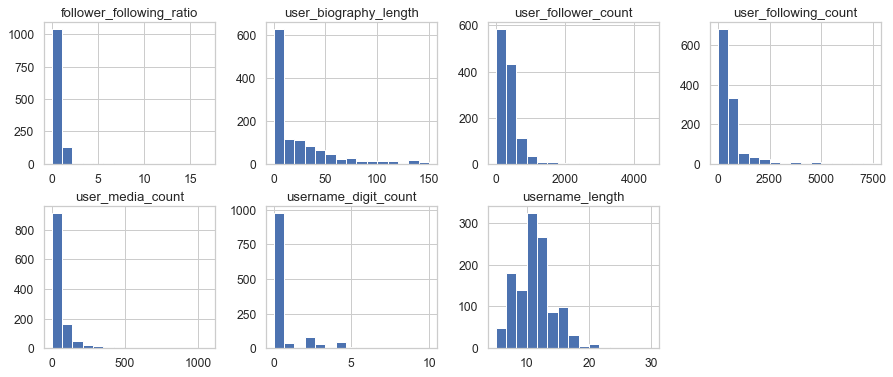

In [127]:
# Histogram
numerical = dataframe.select_dtypes(include = ['int64','float64']).columns
dataframe[numerical].hist(bins=15, figsize=(15, 6), layout=(2, 4))

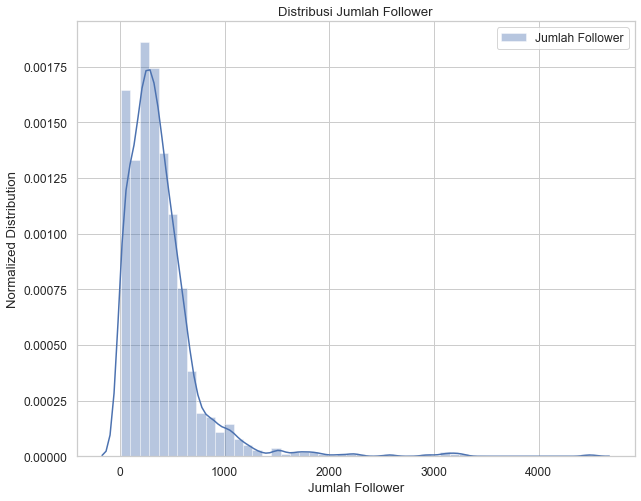

In [129]:
# Distribution Plot
plt.subplots(figsize=(10,8))
sns.distplot(dataframe.user_follower_count[dataframe.user_follower_count > 10], label='Jumlah Follower').legend()

plt.xlabel('Jumlah Follower')
plt.ylabel('Normalized Distribution')
plt.title('Distribusi Jumlah Follower')
plt.show()

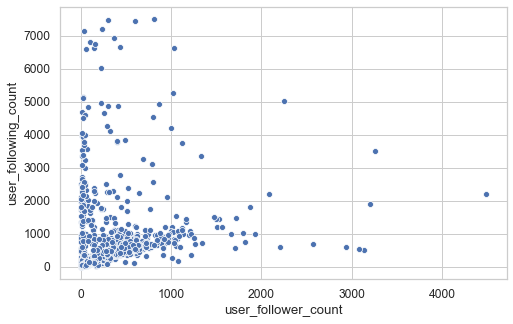

In [135]:
# Scatter Plot
p = sns.scatterplot(x=dataframe['user_follower_count'], y=dataframe['user_following_count'])

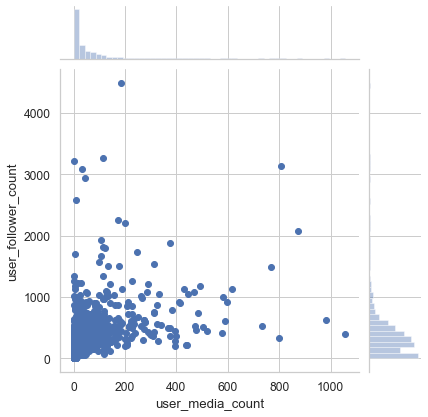

In [139]:
# Joined
p = sns.jointplot(x=dataframe['user_media_count'], y=dataframe['user_follower_count'])

### 6. Basic Statistics

In [16]:
# Statistika deskriptif dari semua variabel(termasuk data kategorik)

dataframe.describe(include='all')

is_fake  follower_following_ratio  user_biography_length  \
count  1194.000000               1194.000000            1194.000000   
mean      0.167504                  0.812195              22.847571   
std       0.373582                  0.804559              33.492868   
min       0.000000                  0.000000               0.000000   
25%       0.000000                  0.481885               0.000000   
50%       0.000000                  0.839351               7.000000   
75%       0.000000                  1.003664              33.000000   
max       1.000000                 16.800000             150.000000   

       user_follower_count  user_following_count  user_has_profil_pic  \
count          1194.000000           1194.000000          1194.000000   
mean            369.095477            744.261307             0.922948   
std             372.775741           1032.526420             0.266786   
min               0.000000              0.000000             0.000000   
25%             152.000000            267.000000             1.000000   
50%             304.000000            449.000000             1.000000   
75%             481.000000            711.000000             1.000000   
max            4492.000000           7497.000000             1.000000   

       user_is_private  user_media_count  username_digit_count  \
count      1194.000000       1194.000000           1194.000000   
mean          0.657454         57.596315              0.495812   
std           0.474760        107.402157              1.212010   
min           0.000000          0.000000              0.000000   
25%           0.000000          3.000000              0.000000   
50%           1.000000         20.000000              0.000000   
75%           1.000000         67.000000              0.000000   
max           1.000000       1058.000000             10.000000   

       username_length  
count      1194.000000  
mean         11.123953  
std           2.998135  
min           5.000000  
25%           9.000000  
50%          11.000000  
75%          13.000000  
max          30.000000

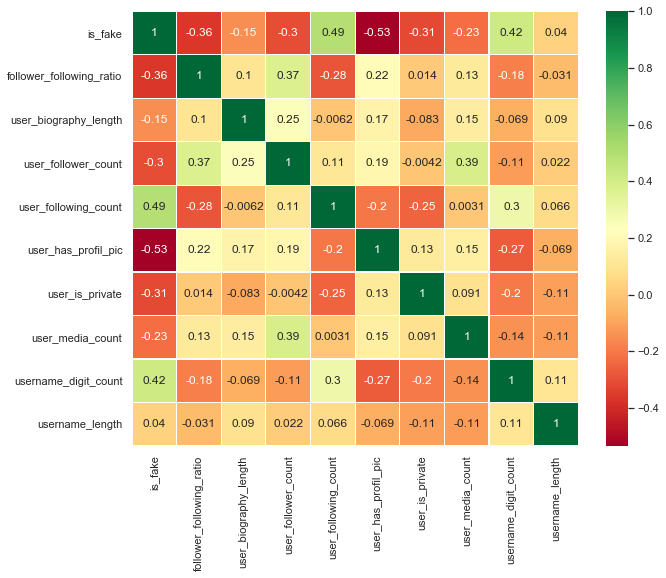

In [17]:
# Melihat heatmap untuk mengetahui korelasi antarvariabel

sns.heatmap(dataframe.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

### 7. Model Training

In [16]:
# Menyetel beberapa parameter

params = {
    # Secara default jumlah iterasi = 1000. Jika menurunkan jumlah iterasi maka learning rate ditingkatkan agar proses konvergen.
    'iterations': 500, 
    'learning_rate': 0.46181411601283945,  # Diperoleh dari hasil parameter tuning
    'custom_metric': ['Accuracy', 'AUC', 'Precision', 'Recall', 'F1'],
    'loss_function': 'Logloss',
    'random_seed': 42,
    'l2_leaf_reg' : 4.0,               # Untuk meningkatkan kualitas model, diperoleh dari hasil parameter tuning
    # Parameter logging_level:
    # Verbose: Keluarkan data berikut ke stdout berupa
    # Metrik yang dioptimalkan, waktu pelatihan yang telah berlalu, sisa waktu pelatihan
    #-Info: Menampilkan informasi tambahan dan jumlah pohon.
    #-Debug: Keluarkan informasi debugging
    
    # Ansambel pohon yang dihasilkan menyusut ke iterasi terbaik.
    # Model dikecilkan menjadi beberapa pohon ketika mendapatkan nilai metrik evaluasi terbaik pada dataset validasi.
    # Jika parameter use_best_model disetel, jumlah pohon yang disimpan dalam model yang dihasilkan ditentukan sebagai berikut:
    #1.membangun jumlah pohon yang ditentukan oleh parameter pelatihan.
    #2.menggunakan data validasi untuk mengidentifikasi iterasi dengan nilai optimal dari metrik yang ditentukan dalam eval_metric.
    #Tidak ada pohon yang disimpan setelah iterasi tersebut. Opsi ini membutuhkan data validasi untuk disediakan.
    'use_best_model': True,  
    # Menggunakan penghentian awal (early stopping) sebagai detektor overfitting. 
    # Dapat meningkatkan kualitas juga tetap dapat menghemat waktu.
    # Akan lebih baik jika menghentikan proses boosting lebih awal (sebelum overfitting dimulai).
    # Menyetel jenis detektor overfitting ke Iter 
    # dan menghentikan pelatihan setelah jumlah iterasi yang ditentukan sejak iterasi dengan nilai metrik yang optimal
    'early_stopping_rounds':40, 
    # Jumlah maksimum fitur yang dapat digabungkan/dikombinasikan.
    # Setiap kombinasi yang dihasilkan terdiri dari satu atau lebih fitur kategoris.
    'max_ctr_complexity': 1,           # Tanpa kombinasi fitur. Akan mempercepat pelatihan
    #-Ordered: Biasanya memberikan kualitas yang lebih baik pada kumpulan data kecil, tetapi mungkin lebih lambat daripada skema Plain.
    #-Plain: Skema peningkatan gradien klasik.
    'boosting_type': 'Ordered',          # Secara default menggunakan ordered untuk menghindari overfitting, tetapi komputasi besar
    'bootstrap_type': 'Bayesian',      # Menggunakan bootstrap_type eksponensial(default)
    'leaf_estimation_method':'Newton'  # Sepuluh terasi Newton.
}

In [17]:
%%time
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validation_pool, logging_level='Info', plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

follower_following_ratio, bin=37 score 14.15466383
user_media_count, bin=160 score 14.6341599
user_has_profil_pic, value=1 score 15.23108132
follower_following_ratio, bin=198 score 14.84613016
user_follower_count, bin=242 score 14.35836534
username_length, bin=15 score 15.04855948
0:	learn: 0.2108848	test: 0.2328728	best: 0.2328728 (0)	total: 12.1ms	remaining: 6.02s

follower_following_ratio, bin=26 score 4.405853944
user_has_profil_pic, value=1 score 4.478403176
user_has_profil_pic, value=1 score 4.615768796
  tensor 1 is redundant, remove it and stop
1:	learn: 0.1441194	test: 0.1694990	best: 0.1694990 (1)	total: 16.7ms	remaining: 4.17s

user_media_count, bin=2 score 1.804601671
user_follower_count, bin=191 score 2.467446037
user_following_count, bin=92 score 2.605045501
username_digit_count, bin=5 score 2.841344661
user_follower_count, bin=190 score 2


user_following_count, bin=2 score 0.8080171847
user_following_count, bin=0 score 0.8826822914
user_media_count, bin=196 score 0.8953218059
user_media_count, bin=199 score 0.8969674617
user_media_count, bin=195 score 0.8983186986
user_media_count, bin=203 score 0.8988268787
38:	learn: 0.0224101	test: 0.0889286	best: 0.0886873 (36)	total: 369ms	remaining: 4.36s

user_following_count, bin=2 score 0.9357411842
user_biography_length, bin=112 score 1.039600931
user_media_count, bin=33 score 1.104600028
user_media_count, bin=110 score 1.134289612
user_following_count, bin=253 score 1.153877013
user_media_count, bin=104 score 1.168807444
39:	learn: 0.0223523	test: 0.0889191	best: 0.0886873 (36)	total: 380ms	remaining: 4.37s

follower_following_ratio, bin=45 score 0.5374753906
follower_following_ratio, bin=31 score 0.9515811973
follower_following_ratio, bin=40 score 1.078208242
username_length, bin=14 score 1.219855636
follower_following_ratio, bin=49 score 1.341322793
username_digit_count, bi

user_biography_length, bin=120 score 0.9170953185
user_media_count, bin=193 score 0.9200340696
70:	learn: 0.0122081	test: 0.0895206	best: 0.0882750 (65)	total: 715ms	remaining: 4.32s

user_following_count, bin=2 score 0.7599029717
user_media_count, bin=164 score 0.8192158179
user_biography_length, bin=118 score 0.8353697069
user_follower_count, bin=248 score 0.8499345974
username_digit_count, bin=6 score 0.8908393006
user_follower_count, bin=249 score 0.9292857892
71:	learn: 0.0121991	test: 0.0895218	best: 0.0882750 (65)	total: 726ms	remaining: 4.32s

user_media_count, bin=4 score 0.6275680984
user_biography_length, bin=70 score 1.125339892
follower_following_ratio, bin=40 score 1.326169411
user_biography_length, bin=98 score 1.477057303
user_following_count, bin=22 score 1.593356524
follower_following_ratio, bin=63 score 1.728343628
72:	learn: 0.0118025	test: 0.0876719	best: 0.0876719 (72)	total: 736ms	remaining: 4.3s

user_following_count, bin=2 score 1.311176507
user_biography_lengt

follower_following_ratio, bin=27 score 1.510480731
user_following_count, bin=253 score 1.523530745
100:	learn: 0.0062720	test: 0.0830334	best: 0.0818174 (97)	total: 1.08s	remaining: 4.26s

follower_following_ratio, bin=36 score 0.5906500949
user_biography_length, bin=0 score 0.888872111
user_biography_length, bin=112 score 0.9459944548
follower_following_ratio, bin=246 score 0.9975070791
user_media_count, bin=73 score 1.052696464
user_following_count, bin=1 score 1.087239207
101:	learn: 0.0062133	test: 0.0829286	best: 0.0818174 (97)	total: 1.09s	remaining: 4.26s

follower_following_ratio, bin=144 score 0.5032936136
user_media_count, bin=2 score 0.7387102419
user_biography_length, bin=10 score 1.535469532
username_digit_count, bin=0 score 1.835115255
user_follower_count, bin=189 score 2.096638985
user_follower_count, bin=17 score 2.312336823
102:	learn: 0.0059034	test: 0.0839004	best: 0.0818174 (97)	total: 1.1s	remaining: 4.25s

username_length, bin=10 score 0.378025302
user_follower_co

user_follower_count, bin=46 score 1.090647342
username_length, bin=2 score 1.233059029
130:	learn: 0.0043026	test: 0.0865702	best: 0.0818174 (97)	total: 1.43s	remaining: 4.03s

user_media_count, bin=0 score 0.5905014253
user_following_count, bin=3 score 1.016958913
user_follower_count, bin=18 score 1.068095159
user_media_count, bin=3 score 1.203678078
username_length, bin=2 score 1.287214521
username_digit_count, bin=4 score 1.329075233
131:	learn: 0.0042395	test: 0.0877151	best: 0.0818174 (97)	total: 1.44s	remaining: 4.02s

user_following_count, bin=2 score 0.7755030498
user_media_count, bin=11 score 0.9963107866
user_follower_count, bin=132 score 1.180000484
user_following_count, bin=252 score 1.220264448
user_follower_count, bin=243 score 1.247304834
user_follower_count, bin=250 score 1.299770444
132:	learn: 0.0042316	test: 0.0874811	best: 0.0818174 (97)	total: 1.45s	remaining: 4.01s

user_media_count, bin=4 score 0.2826823135
user_follower_count, bin=196 score 0.8476049616
user_bio

Dengan ini kita dapat melihat bahwa nilai akurasi terbaik sebesar 0.9791 yang dicapat pada 86 langkah boosting.

In [10]:
print('Jumlah Pohon: {}'.format(model.tree_count_))
print('Akurasi Model: {:.4}'.format(
    accuracy_score(y_validation, model.predict(x_validation))  # Dilihat dari data validasi
))

Jumlah Pohon: 98
Akurasi Model: 0.9791


In [10]:
# Melihat metric evaluasi
# Metrik yang digunakan untuk deteksi overfitting (jika diaktifkan) 
# dan pemilihan model terbaik (jika diaktifkan). Beberapa metrik mendukung parameter opsional.

metric = model.eval_metrics(
    data=validation_pool,
    metrics=['Logloss','AUC'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [31]:
print('AUC values:')
print(np.array(metric['AUC']))

AUC values:
[0.96209929 0.9654552  0.98005617 0.99268974 0.9940587  0.99489181
 0.99539246 0.99584618 0.99660497 0.99721514 0.99767276 0.99771188
 0.99773534 0.99792309 0.99787615 0.9978918  0.99789962 0.99792309
 0.99836898 0.99840027 0.99840027 0.99843938 0.9984785  0.99871317
 0.99883051 0.99882269 0.99886181 0.9989635  0.99919427 0.99919427
 0.99921774 0.99927249 0.99960887 0.99963234 0.99963234 0.99963234
 0.99963234 0.99977314 0.99977314 0.99977314 0.99978879 0.99991395
 0.9999296  0.9999296  0.9999296  0.9999296  0.9999296  0.99994524
 0.99995306 0.99995306 0.99995306 0.99995306 0.99995306 0.99995306
 0.99995306 0.99996871 0.99997653 0.99997653 0.99997653 0.99997653
 0.99997653 0.99997653 0.99997653 0.99997653 0.99997653 0.99997653
 0.99997653 0.99997653 0.99997653 0.99997653 0.99997653 0.99997653
 0.99998435 0.99998435 0.99999218 1.         1.         1.
 0.99999218 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.    

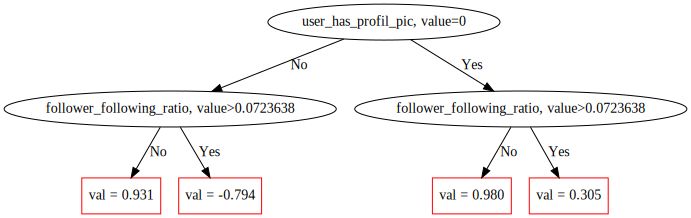

In [11]:
# Visualisasi Pohon

os.environ["PATH"] += os.pathsep + 'C:/Users/dell latitude/anaconda3/Library/bin/graphviz/'

model.plot_tree(
    tree_idx=1,
    pool=train_pool     # "pool" adalah parameter wajib untuk pohon dengan minimal satu fitur kategorik
)

Pohon pertama hanya berisi satu split yang dibuat oleh fitur kategorik user_has_profil_pic. Split ini menempatkan objek yang tidak memiliki foto profil (No) ke kiri dan objek yang memilki foto profil (Yes) ke kanan.

CatBoost menggunakan pohon simetris atau pohon oblivious. Untuk setiap tingkat pohon CatBoost menggunakan fitur yang sama untuk membagi contoh pembelajaran ke partisi kiri dan kanan. Pada pohon tingkat pertama dipartisi dengan pemisahan pertama menjadi dua bagian, pada tingkat kedua setiap subpohon dibagi dengan pemisahan kedua dan seterusnya.

Dalam hal ini pohon dengan kedalaman 𝑘 memiliki tepat $2^𝑘$ daun dan $𝑘$ split, masing-masing terpisah pada lapisan berikutnya.

Ada tiga jenis pemisahan (split): "FloatFeature", "OneHotFeature", dan "OnlineCtr". Model tanpa fitur kategoris hanya berisi split "FloatFeature".

### 8. Feature Selection

In [10]:
# Melihat fitur mana yang paling penting untuk model

model.get_feature_importance(prettified=True)

Feature Id  Importances
0  follower_following_ratio    35.538291
1          user_media_count    22.299620
2      user_following_count    10.520514
3           username_length     7.284885
4       user_follower_count     6.981056
5       user_has_profil_pic     6.333719
6           user_is_private     4.899425
7     user_biography_length     3.927455
8      username_digit_count     2.215036

Terlihat bahwa fitur **`follower_following_ratio`** memiliki pengaruh terbesar terhadap hasil. 

In [11]:
# Menghapus beberapa fitur yang hanya memiliki sedikit pengaruh terhadap model
# Berdasarkan tabel feature importances dilihat tiga fitur terbawah.
# Sehingga fitur yang akan dihapus yaitu username_digit_count, username_length, dan user_biography_length.

data_feature_selection = dataframe.drop(['username_digit_count','user_is_private','user_biography_length'], axis=1)

In [14]:
data_feature_selection.head()

is_fake  follower_following_ratio  user_follower_count  \
0        1                  0.012907                 25.0   
1        1                  0.078603                324.0   
2        1                  0.037594                 15.0   
3        1                  0.130841                 14.0   
4        1                  0.056762                264.0   

   user_following_count  user_has_profil_pic  user_media_count  \
0                1937.0                    1               0.0   
1                4122.0                    1               0.0   
2                 399.0                    0               0.0   
3                 107.0                    1               1.0   
4                4651.0                    1               0.0   

   username_length  
0             10.0  
1             15.0  
2             12.0  
3             10.0  
4             14.0

In [59]:
# Mencetak Nama Kolom
print(data_feature_selection.columns.values)  

['is_fake' 'follower_following_ratio' 'user_follower_count'
 'user_following_count' 'user_has_profil_pic' 'user_media_count'
 'username_length']


### 9. Pemilihan Model Terbaik

In [18]:
def print_cv_summary(cv_data):

    # Melihat nilai rata-rata dan standar deviasi Logloss untuk cross validation pada iterasi terbaik.
    print('\nBest Logloss Score : {:.2f}±{:.2f} pada step {}'.format(
        np.min(cv_data['test-Logloss-mean']),
        cv_data['test-Logloss-std'][np.argmin(cv_data['test-Logloss-mean'])],
        np.argmin(cv_data['test-Logloss-mean'])
    ))
    # Melihat nilai fungsi kerugian di setiap langkah boosting yang dirata-rata sebanyak folds, 
    # yang dapat memberi perkiraan lebih akurat tentang kinerja model
    print('Precise Logloss Score: {}'.format(np.min(cv_data['test-Logloss-mean'])))

    # Melihat nilai rata-rata dan standar deviasi Akurasi
    print('\nBest Accuracy Score: {:.2f}±{:.2f} pada step {}'.format(
        np.max(cv_data['test-Accuracy-mean']),
        cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
        np.argmax(cv_data['test-Accuracy-mean'])
    ))
    print('Precise Accuracy Score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))
    
    # Melihat nilai rata-rata dan standar deviasi AUC  
    print('\nBest AUC Score: {:.2f}±{:.2f} pada step {}'.format(
        np.max(cv_data['test-AUC-mean']),
        cv_data['test-AUC-std'][np.argmax(cv_data['test-AUC-mean'])],
        np.argmax(cv_data['test-AUC-mean'])
    ))
    print('Precise AUC Score: {}'.format(np.max(cv_data['test-AUC-mean'])))
    
    # Melihat nilai rata-rata dan standar deviasi Precision  
    print('\nBest Precision Score: {:.2f}±{:.2f} pada step {}'.format(
        np.max(cv_data['test-Precision-mean']),
        cv_data['test-Precision-std'][np.argmax(cv_data['test-Precision-mean'])],
        np.argmax(cv_data['test-Precision-mean'])
    ))
    print('Precise Precision Score: {}'.format(np.max(cv_data['test-Precision-mean'])))
    
    
    # Melihat nilai rata-rata dan standar deviasi Recall  
    print('\nBest Recall Score: {:.2f}±{:.2f} pada step {}'.format(
        np.max(cv_data['test-Recall-mean']),
        cv_data['test-Recall-std'][np.argmax(cv_data['test-Recall-mean'])],
        np.argmax(cv_data['test-Recall-mean'])
    ))
    print('Precise Recall Score: {}'.format(np.max(cv_data['test-Recall-mean'])))
    
    # Melihat nilai rata-rata dan standar deviasi F1  
    print('\nBest F1 Score: {:.2f}±{:.2f} pada step {}'.format(
        np.max(cv_data['test-F1-mean']),
        cv_data['test-F1-std'][np.argmax(cv_data['test-F1-mean'])],
        np.argmax(cv_data['test-F1-mean'])
    ))
    print('Precise F1 Score: {}'.format(np.max(cv_data['test-F1-mean'])))

#### 1) Tanpa SMOTE-NC Tanpa Feature Selection

In [21]:
%%time

model1_params = params.copy()
model1_params.update({
    'train_dir' :'Model_1'
})

model1_cv = cv(
    params = model1_params,
    pool = train_pool,
    verbose = 10,
    plot = True,
    fold_count = 5,
    stratified=False,
)

print_cv_summary(model1_cv)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2129494	test: 0.2189622	best: 0.2189622 (0)	total: 181ms	remaining: 1m 30s
10:	learn: 0.0472799	test: 0.1020427	best: 0.1016704 (9)	total: 2.17s	remaining: 1m 36s
20:	learn: 0.0305512	test: 0.1029413	best: 0.0982535 (14)	total: 4.31s	remaining: 1m 38s
30:	learn: 0.0207878	test: 0.1103626	best: 0.0982535 (14)	total: 6.44s	remaining: 1m 37s
40:	learn: 0.0145660	test: 0.1142551	best: 0.0982535 (14)	total: 8.54s	remaining: 1m 35s
50:	learn: 0.0108133	test: 0.1156416	best: 0.0982535 (14)	total: 11s	remaining: 1m 37s
Stopped by overfitting detector  (40 iterations wait)

Best Logloss Score : 0.10±0.02 pada step 14
Precise Logloss Score: 0.09825348722069709

Best Accuracy Score: 0.97±0.01 pada step 13
Precise Accuracy Score: 0.968586387434555

Best AUC Score: 0.99±0.01 pada step 14
Precise AUC Score: 0.9907786487514716

Best Precision Score: 0.92±0.04 pada step 19
Precise Precision Score: 0.9233719983719985

Best Recall Score: 0.89±0.06 pada step 9
Precise Recall Score: 0.89194674

In [77]:
model1_cv.head(5)

iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0           0           0.218962          0.025973            0.212949   
1           1           0.141974          0.027979            0.135265   
2           2           0.119620          0.030717            0.103702   
3           3           0.109351          0.026444            0.087751   
4           4           0.106018          0.020777            0.076214   

   train-Logloss-std  test-Accuracy-mean  test-Accuracy-std  \
0           0.023844            0.949738           0.012053   
1           0.018050            0.953927           0.018287   
2           0.012443            0.960209           0.019094   
3           0.009280            0.964398           0.017126   
4           0.006437            0.962304           0.008603   

   train-Accuracy-mean  train-Accuracy-std  test-AUC-mean  ...  \
0             0.952094            0.005750       0.965259  ...   
1             0.959162            0.009411       0.984015  ...   
2             0.969634            0.005428       0.983226  ...   
3             0.973560            0.003970       0.985706  ...   
4             0.975916            0.004590       0.987610  ...   

   train-Precision-mean  train-Precision-std  test-Recall-mean  \
0              0.854148             0.054345          0.865482   
1              0.910099             0.030208          0.827657   
2              0.917814             0.024938          0.865320   
3              0.928987             0.021960          0.878224   
4              0.936839             0.021502          0.866770   

   test-Recall-std  train-Recall-mean  train-Recall-std  test-F1-mean  \
0         0.072095           0.869872          0.045766      0.853500   
1         0.140103           0.841863          0.058987      0.853126   
2         0.101894           0.900682          0.016175      0.877626   
3         0.090969           0.912951          0.010884      0.889593   
4         0.075898           0.919082          0.018645      0.883810   

   test-F1-std  train-F1-mean  train-F1-std  
0     0.030600       0.859767      0.012447  
1     0.071121       0.873397      0.032689  
2     0.063974       0.909024      0.016618  
3     0.057386       0.920785      0.012860  
4     0.033375       0.927714      0.014748  

[5 rows x 23 columns]

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

follower_following_ratio, bin=37 score 14.15466383
user_media_count, bin=160 score 14.6341599
user_has_profil_pic, value=1 score 15.23108132
follower_following_ratio, bin=198 score 14.84613016
user_follower_count, bin=242 score 14.35836534
username_length, bin=15 score 15.04855948
0:	learn: 0.2108848	test: 0.2328728	best: 0.2328728 (0)	total: 13.9ms	remaining: 6.93s

follower_following_ratio, bin=26 score 4.405853944
user_has_profil_pic, value=1 score 4.478403176
user_has_profil_pic, value=1 score 4.615768796
  tensor 1 is redundant, remove it and stop
1:	learn: 0.1441194	test: 0.1694990	best: 0.1694990 (1)	total: 18.4ms	remaining: 4.58s

user_media_count, bin=2 score 1.804601671
user_follower_count, bin=191 score 2.467446037
user_following_count, bin=92 score 2.605045501
username_digit_count, bin=5 score 2.841344661
user_follower_count, bin=190 score 2

user_biography_length, bin=112 score 1.119175887
follower_following_ratio, bin=246 score 1.157262768
user_biography_length, bin=71 score 1.184071641
user_follower_count, bin=248 score 1.203409655
36:	learn: 0.0235851	test: 0.0886873	best: 0.0886873 (36)	total: 358ms	remaining: 4.48s

user_following_count, bin=1 score 0.8594339639
user_media_count, bin=9 score 0.9865713559
follower_following_ratio, bin=160 score 1.440053472
user_has_profil_pic, value=1 score 1.697120836
user_following_count, bin=3 score 1.947424409
username_digit_count, bin=4 score 1.975424659
37:	learn: 0.0224144	test: 0.0888595	best: 0.0886873 (36)	total: 372ms	remaining: 4.53s

user_following_count, bin=2 score 0.8080171847
user_following_count, bin=0 score 0.8826822914
user_media_count, bin=196 score 0.8953218059
user_media_count, bin=199 score 0.8969674617
user_media_count, bin=195 score 0.8983186986
user_media_count, bin=203 score 0.8988268787
38:	learn: 0.0224101	test: 0.0889286	best: 0.0886873 (36)	total: 383ms	

username_digit_count, bin=6 score 1.50459335
73:	learn: 0.0118020	test: 0.0876870	best: 0.0876719 (72)	total: 713ms	remaining: 4.1s

user_media_count, bin=3 score 0.7654817807
follower_following_ratio, bin=26 score 0.9666863002
user_follower_count, bin=37 score 1.222906117
follower_following_ratio, bin=16 score 1.394677281
user_biography_length, bin=85 score 1.495254324
username_digit_count, bin=2 score 1.662962955
74:	learn: 0.0114042	test: 0.0899111	best: 0.0876719 (72)	total: 726ms	remaining: 4.11s

user_media_count, bin=1 score 0.4605207415
user_following_count, bin=4 score 0.7364325806
user_follower_count, bin=16 score 1.119367601
user_following_count, bin=199 score 1.250753793
user_is_private, value=1 score 1.388307453
username_length, bin=2 score 1.453918744
75:	learn: 0.0109267	test: 0.0883006	best: 0.0876719 (72)	total: 739ms	remaining: 4.12s

user_following_count, bin=222 score 0.811196712
user_following_count, bin=2 score 0.9624419978
user_following_count, bin=3 score 1.2505

104:	learn: 0.0058609	test: 0.0839296	best: 0.0818174 (97)	total: 1.07s	remaining: 4.03s

user_media_count, bin=7 score 0.3787943022
user_follower_count, bin=195 score 0.6253537267
user_biography_length, bin=43 score 0.7744795004
user_following_count, bin=4 score 0.8459385917
user_biography_length, bin=98 score 0.9367659917
follower_following_ratio, bin=253 score 0.9830592839
105:	learn: 0.0058045	test: 0.0840912	best: 0.0818174 (97)	total: 1.08s	remaining: 4.03s

follower_following_ratio, bin=32 score 0.4223814651
follower_following_ratio, bin=40 score 0.9596306065
user_following_count, bin=249 score 1.015595823
follower_following_ratio, bin=250 score 1.061167523
user_following_count, bin=1 score 1.099280585
username_length, bin=2 score 1.140755993
106:	learn: 0.0057791	test: 0.0839418	best: 0.0818174 (97)	total: 1.09s	remaining: 4.01s

user_following_count, bin=1 score 0.7902678837
user_following_count, bin=222 score 0.9753123689
user_biography_length, bin=117 score 0.9947714158
user

137:	learn: 0.0039794	test: 0.0878787	best: 0.0818174 (97)	total: 1.43s	remaining: 3.74s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.0818174271
bestIteration = 97

Shrink model to first 98 iterations.
Wall time: 1.55 s


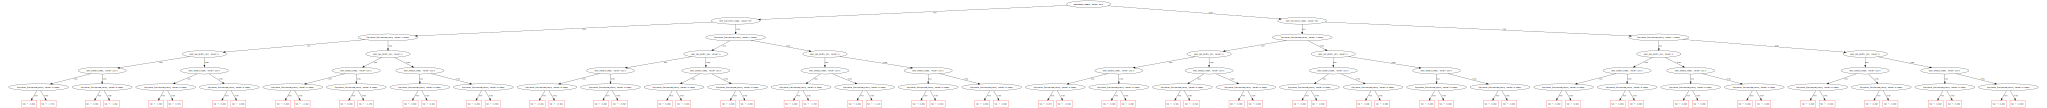

In [22]:
%%time

os.environ["PATH"] += os.pathsep + 'C:/Users/dell latitude/anaconda3/Library/bin/graphviz/'

model1 = CatBoostClassifier(**params).fit(train_pool, eval_set=validation_pool, logging_level='Info')

# Visualisasi Pohon
model1.plot_tree(
    tree_idx=0,
    pool=train_pool
)

In [24]:
model1.get_borders()

{0: [0.00246962858363986,
  0.003860961180180311,
  0.004722963087260723,
  0.00604205671697855,
  0.008593697100877762,
  0.010229029692709446,
  0.02042187564074993,
  0.02253499999642372,
  0.03194581717252731,
  0.039822254329919815,
  0.06650655716657639,
  0.06871029734611511,
  0.07236380130052567,
  0.08623401820659637,
  0.08871123939752579,
  0.10341088473796844,
  0.12344183027744293,
  0.12809768319129944,
  0.1391831934452057,
  0.15822041034698486,
  0.1774909496307373,
  0.18218189477920532,
  0.2019907534122467,
  0.21422554552555084,
  0.25294893980026245,
  0.28496599197387695,
  0.30986446142196655,
  0.3388161063194275,
  0.3496588468551636,
  0.38338518142700195,
  0.41475340723991394,
  0.4307534694671631,
  0.44286853075027466,
  0.45539921522140503,
  0.457618772983551,
  0.48079127073287964,
  0.5466552376747131,
  0.6010974049568176,
  0.6103912591934204,
  0.6163815259933472,
  0.6459866762161255,
  0.7173997163772583,
  0.7365825176239014,
  0.87292718887329

In [95]:
print('Jumlah Pohon: {}'.format(model1.tree_count_))

Jumlah Pohon: 98


=== Confusion Matrix ===
[[199   1]
 [  4  35]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       200
           1       0.97      0.90      0.93        39

    accuracy                           0.98       239
   macro avg       0.98      0.95      0.96       239
weighted avg       0.98      0.98      0.98       239



Accuracy: 0.9790794979079498
F1_score: 0.9333333333333333
Recall_score: 0.8974358974358975
AUC_score: 0.9462179487179486
Sensitivity 0.8974358974358975
Specificity 0.995
Precision 0.9722222222222222


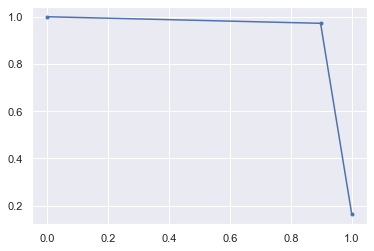

In [152]:
# Prediksi pada data test
model_predict=model1.predict(x_validation)

print("=== Confusion Matrix ===")
print(confusion_matrix(y_validation, model_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_validation, model_predict))
print('\n')

# Akurasi Model

print("Accuracy:",metrics.accuracy_score(y_validation, model_predict))
print("F1_score:",metrics.f1_score(y_validation, model_predict))
print("Recall_score:",metrics.recall_score(y_validation, model_predict))
print("AUC_score:",metrics.roc_auc_score(y_validation, model_predict))
precision, recall, thresholds = metrics.precision_recall_curve(y_validation, model_predict)

plt.plot(recall, precision, marker='.')

confusion = confusion_matrix(y_validation, model_predict)

# True Positives
TP = confusion[1, 1]
# True Negatives
TN = confusion[0, 0]
# False Positives
FP = confusion[0, 1]
# False Negatives
FN = confusion[1, 0]
print("Sensitivity",TP / float(TP + FN))
print("Specificity",TN / float(TN + FP))
print("Precision",TP / float(TP + FP))

#### 2) Tanpa SMOTE-NC Dengan  Feature Selection

In [23]:
# Mencetak Nama Fitur-fitur yang Digunakan
print(data_feature_selection.columns.values)  

['is_fake' 'follower_following_ratio' 'user_follower_count'
 'user_following_count' 'user_has_profil_pic' 'user_media_count'
 'username_length']


In [22]:
# Membuat pool class baru setelah feature selection

cat_features_selection =['user_has_profil_pic']

x_train2 = x_train.drop(['username_digit_count','user_is_private','user_biography_length'], axis=1) 
y_train2 = y_train

x_validation2 = x_validation.drop(['username_digit_count','user_is_private','user_biography_length'], axis=1)
y_validation2 = y_validation

train2_pool = Pool(data=x_train2, label=y_train2, cat_features=cat_features_selection)
validation2_pool = Pool(data=x_validation2, label=y_validation2, cat_features=cat_features_selection)

print("{:<20}{}".format("Train size:", x_train2.shape))
print("{:<20}{}".format("Validation size:", x_validation2.shape))

Train size:         (955, 6)
Validation size:    (239, 6)


In [23]:
%%time

model2_params = params.copy()
model2_params.update({
    'train_dir' :'Model_2'
})

model2_cv = cv(
    params = model2_params,
    pool = train2_pool,
    verbose = 10,
    plot = True,
    fold_count = 5,
    stratified=False
)

print_cv_summary(model2_cv)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2041204	test: 0.2124239	best: 0.2124239 (0)	total: 213ms	remaining: 1m 46s
10:	learn: 0.0517159	test: 0.1107785	best: 0.1107785 (10)	total: 2.2s	remaining: 1m 37s
20:	learn: 0.0320720	test: 0.1092101	best: 0.1060750 (16)	total: 4.83s	remaining: 1m 50s
30:	learn: 0.0212748	test: 0.1165721	best: 0.1060750 (16)	total: 6.77s	remaining: 1m 42s
40:	learn: 0.0143985	test: 0.1212459	best: 0.1060750 (16)	total: 8.7s	remaining: 1m 37s
50:	learn: 0.0111269	test: 0.1261377	best: 0.1060750 (16)	total: 11.1s	remaining: 1m 37s
Stopped by overfitting detector  (40 iterations wait)

Best Logloss Score : 0.11±0.03 pada step 16
Precise Logloss Score: 0.10607496687595104

Best Accuracy Score: 0.96±0.02 pada step 33
Precise Accuracy Score: 0.9643979057591624

Best AUC Score: 0.99±0.01 pada step 17
Precise AUC Score: 0.989220950677393

Best Precision Score: 0.91±0.05 pada step 13
Precise Precision Score: 0.9107522143992732

Best Recall Score: 0.90±0.04 pada step 0
Precise Recall Score: 0.9040166

In [114]:
model2_cv.head(5)

iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0           0           0.212424          0.008935            0.204120   
1           1           0.154069          0.014003            0.131898   
2           2           0.129397          0.015992            0.101981   
3           3           0.117574          0.020416            0.082103   
4           4           0.116446          0.023288            0.074426   

   train-Logloss-std  test-Accuracy-mean  test-Accuracy-std  \
0           0.004259            0.958115           0.013348   
1           0.012622            0.951832           0.013552   
2           0.010108            0.958115           0.007404   
3           0.008188            0.956021           0.012053   
4           0.006636            0.957068           0.010071   

   train-Accuracy-mean  train-Accuracy-std  test-AUC-mean  ...  \
0             0.962827            0.002378       0.973938  ...   
1             0.963874            0.003413       0.974620  ...   
2             0.971466            0.001941       0.984368  ...   
3             0.974084            0.003632       0.986203  ...   
4             0.975916            0.002378       0.984792  ...   

   train-Precision-mean  train-Precision-std  test-Recall-mean  \
0              0.866277             0.017076          0.904017   
1              0.902256             0.026687          0.826158   
2              0.916393             0.013894          0.857422   
3              0.926659             0.013286          0.856992   
4              0.931841             0.017727          0.857408   

   test-Recall-std  train-Recall-mean  train-Recall-std  test-F1-mean  \
0         0.042567           0.922268          0.010276      0.879012   
1         0.097449           0.883365          0.048427      0.849994   
2         0.047310           0.914391          0.016845      0.872819   
3         0.014667           0.919018          0.019230      0.867714   
4         0.033241           0.925321          0.013924      0.870431   

   test-F1-std  train-F1-mean  train-F1-std  
0     0.039908       0.893240      0.005866  
1     0.052982       0.891452      0.013946  
2     0.023883       0.915222      0.006595  
3     0.035839       0.922702      0.011682  
4     0.029742       0.928383      0.006153  

[5 rows x 23 columns]

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

follower_following_ratio, bin=45 score 13.40664395
follower_following_ratio, bin=15 score 14.47519209
user_follower_count, bin=63 score 14.30225956
user_has_profil_pic, value=1 score 14.11977844
user_has_profil_pic, value=1 score 14.47147077
  tensor 3 is redundant, remove it and stop
0:	learn: 0.2013184	test: 0.1875321	best: 0.1875321 (0)	total: 7.54ms	remaining: 3.76s

follower_following_ratio, bin=36 score 4.496675919
user_media_count, bin=39 score 4.641107676
user_following_count, bin=45 score 4.671703083
user_following_count, bin=77 score 4.447693354
username_length, bin=8 score 4.379504169
user_following_count, bin=235 score 4.538731595
1:	learn: 0.1308456	test: 0.1226077	best: 0.1226077 (1)	total: 16.3ms	remaining: 4.07s

follower_following_ratio, bin=28 score 2.405828152
user_has_profil_pic, value=1 score 2.989711075
user_follower_count, bin=59 

user_media_count, bin=16 score 1.95470972
user_follower_count, bin=244 score 2.170863594
user_following_count, bin=252 score 2.253660555
user_following_count, bin=48 score 2.325542187
user_follower_count, bin=243 score 2.375754619
42:	learn: 0.0208575	test: 0.0870041	best: 0.0870041 (42)	total: 365ms	remaining: 3.88s

follower_following_ratio, bin=34 score 1.005818574
user_media_count, bin=1 score 1.30313223
follower_following_ratio, bin=44 score 1.635726579
follower_following_ratio, bin=46 score 1.750544915
follower_following_ratio, bin=244 score 1.824202226
follower_following_ratio, bin=48 score 1.835727047
43:	learn: 0.0203489	test: 0.0884433	best: 0.0870041 (42)	total: 376ms	remaining: 3.9s

user_has_profil_pic, value=1 score 0.4878964345
username_length, bin=7 score 0.8445550808
user_media_count, bin=1 score 0.9017191413
user_following_count, bin=220 score 1.107735699
user_following_count, bin=245 score 1.196323915
user_follower_count, bin=199 score 1.280062966
44:	learn: 0.018038

Wall time: 777 ms


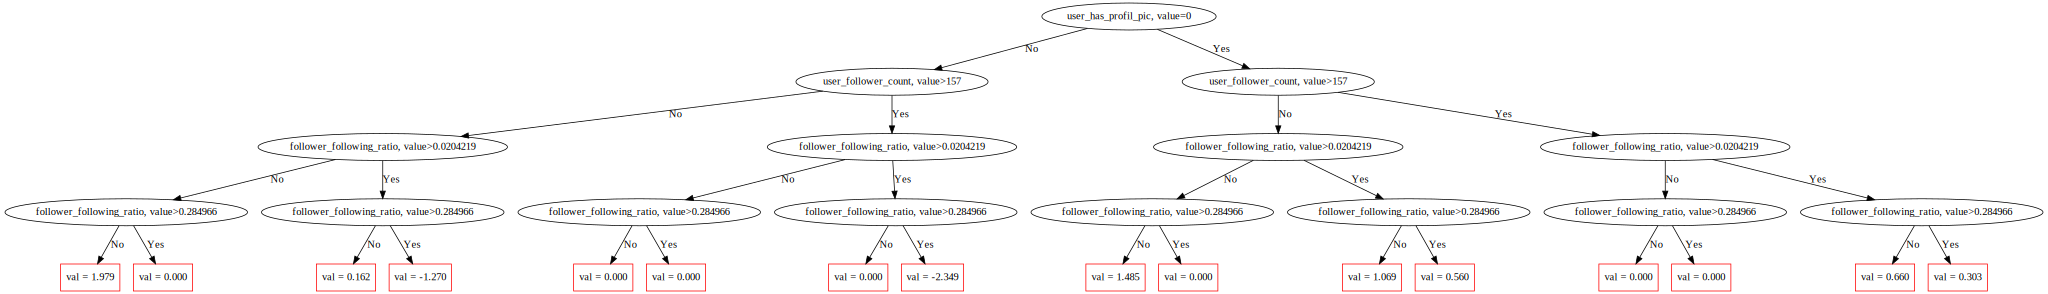

In [21]:
%%time

os.environ["PATH"] += os.pathsep + 'C:/Users/dell latitude/anaconda3/Library/bin/graphviz/'

model2 = CatBoostClassifier(**params).fit(train2_pool, eval_set=validation2_pool, logging_level='Info')

# Visualisasi Pohon
model2.plot_tree(
    tree_idx=0,
    pool=train2_pool
)

In [117]:
print('Jumlah Pohon: {}'.format(model2.tree_count_))

Jumlah Pohon: 43


=== Confusion Matrix ===
[[196   4]
 [  6  33]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       200
           1       0.89      0.85      0.87        39

    accuracy                           0.96       239
   macro avg       0.93      0.91      0.92       239
weighted avg       0.96      0.96      0.96       239



Accuracy: 0.9581589958158996
F1_score: 0.868421052631579
Recall_score: 0.8461538461538461
AUC_score: 0.913076923076923
Sensitivity 0.8461538461538461
Specificity 0.98
Precision 0.8918918918918919


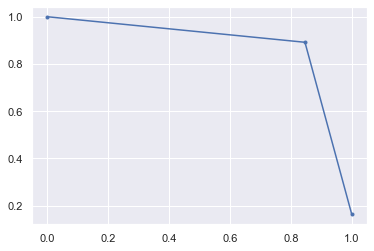

In [153]:
# Prediksi pada data test
model_predict=model2.predict(x_validation2)

print("=== Confusion Matrix ===")
print(confusion_matrix(y_validation2, model_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_validation2, model_predict))
print('\n')

# Akurasi Model

print("Accuracy:",metrics.accuracy_score(y_validation2, model_predict))
print("F1_score:",metrics.f1_score(y_validation2, model_predict))
print("Recall_score:",metrics.recall_score(y_validation2, model_predict))
print("AUC_score:",metrics.roc_auc_score(y_validation2, model_predict))
precision, recall, thresholds = metrics.precision_recall_curve(y_validation2, model_predict)

plt.plot(recall, precision, marker='.')

confusion = confusion_matrix(y_validation2, model_predict)

# True Positives
TP = confusion[1, 1]
# True Negatives
TN = confusion[0, 0]
# False Positives
FP = confusion[0, 1]
# False Negatives
FN = confusion[1, 0]
print("Sensitivity",TP / float(TP + FN))
print("Specificity",TN / float(TN + FP))
print("Precision",TP / float(TP + FP))

#### 3) Dengan SMOTE-NC Tanpa  Feature Selection

In [24]:
train_over_pool = Pool(data=x_over, label=y_over, cat_features=cat_features)

print("{:<20}{}".format("Train size:", x_over.shape[0]))
print("{:<20}{}".format("Validation size:", x_validation.shape[0]))

Train size:         1588
Validation size:    239


In [25]:
%%time

model3_params = params.copy()
model3_params.update({
    'train_dir' :'Model_3'
})

model3_cv = cv(
    params = model3_params,
    pool = train_over_pool,
    verbose = 10,
    plot = True,
    fold_count = 5,
    stratified=False
)

print_cv_summary(model3_cv)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2014967	test: 0.1998505	best: 0.1998505 (0)	total: 216ms	remaining: 1m 47s
10:	learn: 0.0327426	test: 0.0595667	best: 0.0595667 (10)	total: 2.28s	remaining: 1m 41s
20:	learn: 0.0186084	test: 0.0589188	best: 0.0587626 (19)	total: 4.86s	remaining: 1m 50s
30:	learn: 0.0144684	test: 0.0600106	best: 0.0587402 (25)	total: 7.1s	remaining: 1m 47s
40:	learn: 0.0116064	test: 0.0602635	best: 0.0587402 (25)	total: 9.78s	remaining: 1m 49s
50:	learn: 0.0091856	test: 0.0636452	best: 0.0587402 (25)	total: 12.5s	remaining: 1m 49s
60:	learn: 0.0073748	test: 0.0640422	best: 0.0587402 (25)	total: 14.9s	remaining: 1m 47s
Stopped by overfitting detector  (40 iterations wait)

Best Logloss Score : 0.06±0.02 pada step 25
Precise Logloss Score: 0.05874023305606553

Best Accuracy Score: 0.98±0.01 pada step 6
Precise Accuracy Score: 0.9817451342182013

Best AUC Score: 1.00±0.00 pada step 20
Precise AUC Score: 0.9973242006522749

Best Precision Score: 0.98±0.01 pada step 20
Precise Precision Score: 0.

Dengan oversampling SMOTE-NC memberikan peningkatan pada nilai akurasi dari 0.96 menjadi 0.98. Begitu pula skor AUC mengalami peningkatan tetapi tidak signifikan yaitu hanya 0.004.

In [120]:
model3_cv.head(5)

iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0           0           0.198017          0.021185            0.199299   
1           1           0.108232          0.011057            0.102590   
2           2           0.081668          0.012179            0.071474   
3           3           0.072375          0.014342            0.059424   
4           4           0.067409          0.014218            0.053161   

   train-Logloss-std  test-Accuracy-mean  test-Accuracy-std  \
0           0.028311            0.957804           0.009620   
1           0.007371            0.969778           0.007887   
2           0.010093            0.977970           0.007352   
3           0.009365            0.978598           0.007487   
4           0.006546            0.979227           0.007220   

   train-Accuracy-mean  train-Accuracy-std  test-AUC-mean  ...  \
0             0.961590            0.010281       0.988259  ...   
1             0.975128            0.004732       0.994439  ...   
2             0.980951            0.001953       0.995235  ...   
3             0.983156            0.003711       0.995698  ...   
4             0.983943            0.003712       0.995734  ...   

   train-Precision-mean  train-Precision-std  test-Recall-mean  \
0              0.946244             0.026382          0.973144   
1              0.968685             0.011030          0.975946   
2              0.977495             0.006614          0.981050   
3              0.978166             0.006716          0.983678   
4              0.978511             0.007072          0.982255   

   test-Recall-std  train-Recall-mean  train-Recall-std  test-F1-mean  \
0         0.011732           0.979574          0.010308      0.958713   
1         0.005671           0.982086          0.003167      0.969817   
2         0.004506           0.984599          0.004507      0.977833   
3         0.009174           0.988342          0.004305      0.978556   
4         0.011150           0.989610          0.002647      0.979021   

   test-F1-std  train-F1-mean  train-F1-std  
0     0.007390       0.962350      0.009628  
1     0.008364       0.975302      0.004673  
2     0.008058       0.981012      0.002035  
3     0.007839       0.983213      0.003827  
4     0.008179       0.984017      0.003769  

[5 rows x 23 columns]

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

follower_following_ratio, bin=111 score 18.01223109
user_has_profil_pic, value=1 score 18.27444019
username_length, bin=238 score 18.86240845
follower_following_ratio, bin=88 score 18.96380731
user_follower_count, bin=169 score 18.70203928
username_length, bin=178 score 18.91156684
0:	learn: 0.1813715	test: 0.1951914	best: 0.1951914 (0)	total: 19.2ms	remaining: 9.58s

user_media_count, bin=1 score 5.868193757
follower_following_ratio, bin=53 score 6.480323709
user_has_profil_pic, value=1 score 6.946269719
follower_following_ratio, bin=183 score 6.83852358
follower_following_ratio, bin=121 score 6.928721373
user_follower_count, bin=69 score 6.928737461
1:	learn: 0.0855397	test: 0.1142173	best: 0.1142173 (1)	total: 33.3ms	remaining: 8.28s

follower_following_ratio, bin=96 score 2.820247728
user_has_profil_pic, value=1 score 3.24077721
user_follower_count,

user_following_count, bin=143 score 1.143257312
28:	learn: 0.0155555	test: 0.1165105	best: 0.0969487 (9)	total: 361ms	remaining: 5.87s

user_follower_count, bin=80 score 0.2862478066
user_follower_count, bin=81 score 1.401272553
username_digit_count, bin=61 score 1.726882644
user_follower_count, bin=117 score 1.762272724
user_follower_count, bin=95 score 1.783086885
username_length, bin=34 score 1.79610283
29:	learn: 0.0144741	test: 0.1183842	best: 0.0969487 (9)	total: 376ms	remaining: 5.88s

user_biography_length, bin=203 score 0.4483121939
user_biography_length, bin=196 score 0.7033617474
user_media_count, bin=8 score 0.8232128317
follower_following_ratio, bin=82 score 1.046836411
follower_following_ratio, bin=115 score 1.173354419
follower_following_ratio, bin=1 score 1.222530717
30:	learn: 0.0140896	test: 0.1178848	best: 0.0969487 (9)	total: 391ms	remaining: 5.91s

user_biography_length, bin=167 score 0.3048722871
user_follower_count, bin=15 score 0.3988425815
user_is_private, valu

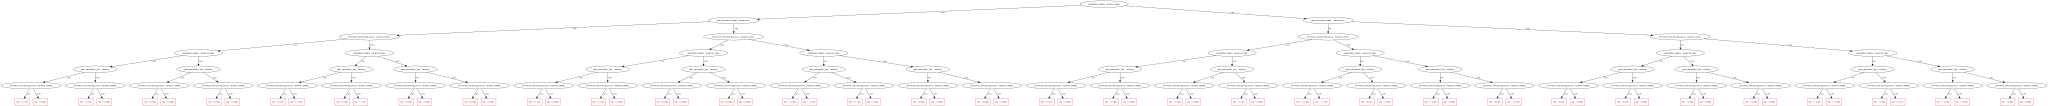

In [29]:
%%time

os.environ["PATH"] += os.pathsep + 'C:/Users/dell latitude/anaconda3/Library/bin/graphviz/'

model3 = CatBoostClassifier(**params).fit(train_over_pool, eval_set=validation_pool, logging_level='Info')

# Visualisasi Pohon
model3.plot_tree(
    tree_idx=0,
    pool=train_over_pool
)

In [28]:
print('Jumlah Pohon: {}'.format(model3.tree_count_))

Jumlah Pohon: 10


=== Confusion Matrix ===
[[197   3]
 [  4  35]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       200
           1       0.92      0.90      0.91        39

    accuracy                           0.97       239
   macro avg       0.95      0.94      0.95       239
weighted avg       0.97      0.97      0.97       239



Accuracy: 0.9707112970711297
F1_score: 0.9090909090909091
Recall_score: 0.8974358974358975
AUC_score: 0.9412179487179486
Sensitivity 0.8974358974358975
Specificity 0.985
Precision 0.9210526315789473


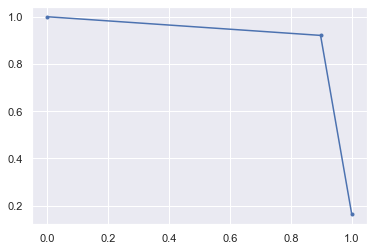

In [154]:
# Prediksi pada data test
model_predict=model3.predict(x_validation)

print("=== Confusion Matrix ===")
print(confusion_matrix(y_validation, model_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_validation, model_predict))
print('\n')

# Akurasi Model

print("Accuracy:",metrics.accuracy_score(y_validation, model_predict))
print("F1_score:",metrics.f1_score(y_validation, model_predict))
print("Recall_score:",metrics.recall_score(y_validation, model_predict))
print("AUC_score:",metrics.roc_auc_score(y_validation, model_predict))
precision, recall, thresholds = metrics.precision_recall_curve(y_validation, model_predict)

plt.plot(recall, precision, marker='.')

confusion = confusion_matrix(y_validation, model_predict)

# True Positives
TP = confusion[1, 1]
# True Negatives
TN = confusion[0, 0]
# False Positives
FP = confusion[0, 1]
# False Negatives
FN = confusion[1, 0]
print("Sensitivity",TP / float(TP + FN))
print("Specificity",TN / float(TN + FP))
print("Precision",TP / float(TP + FP))

#### 4) Dengan SMOTE-NC Dengan Feature Selection

In [131]:
# Mencetak Nama Fitur-fitur yang Digunakan
print(data_feature_selection.columns.values)  

['is_fake' 'follower_following_ratio' 'user_follower_count'
 'user_following_count' 'user_has_profil_pic' 'user_media_count'
 'username_length']


In [26]:
# Membuat pool class baru setelah feature selection
# Menggunakan data train oversampling

x_train4 = x_over.drop(['username_digit_count','user_is_private','user_biography_length'], axis=1) 
y_train4 = y_over

x_validation4 = x_validation.drop(['username_digit_count','user_is_private','user_biography_length'], axis=1)
y_validation4 = y_validation

train4_pool = Pool(data=x_train4, label=y_train4, cat_features=cat_features_selection)
validation4_pool = Pool(data=x_validation4, label=y_validation4, cat_features=cat_features_selection)

print("{:<20}{}".format("Train size:", x_train4.shape))
print("{:<20}{}".format("Validation size:", x_validation4.shape))

Train size:         (1588, 6)
Validation size:    (239, 6)


In [27]:
%%time

model4_params = params.copy()
model4_params.update({
    'train_dir' :'Model_4'
})

model4_cv = cv(
    params = model4_params,
    pool = train4_pool,
    verbose = 10,
    plot = True,
    fold_count = 5,
    stratified=False
)

print_cv_summary(model4_cv)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2027450	test: 0.2060309	best: 0.2060309 (0)	total: 186ms	remaining: 1m 32s
10:	learn: 0.0370574	test: 0.0669053	best: 0.0669053 (10)	total: 2.3s	remaining: 1m 42s
20:	learn: 0.0259944	test: 0.0680534	best: 0.0654584 (15)	total: 4.76s	remaining: 1m 48s
30:	learn: 0.0188368	test: 0.0691238	best: 0.0654584 (15)	total: 7.16s	remaining: 1m 48s
40:	learn: 0.0136371	test: 0.0678643	best: 0.0654584 (15)	total: 9.16s	remaining: 1m 42s
50:	learn: 0.0113470	test: 0.0678182	best: 0.0654584 (15)	total: 11.7s	remaining: 1m 43s
Stopped by overfitting detector  (40 iterations wait)

Best Logloss Score : 0.07±0.02 pada step 15
Precise Logloss Score: 0.0654583846291799

Best Accuracy Score: 0.98±0.01 pada step 47
Precise Accuracy Score: 0.9804892565918696

Best AUC Score: 1.00±0.00 pada step 50
Precise AUC Score: 0.9971017801895847

Best Precision Score: 0.98±0.02 pada step 14
Precise Precision Score: 0.9771793101567209

Best Recall Score: 0.99±0.01 pada step 0
Precise Recall Score: 0.986124

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

follower_following_ratio, bin=115 score 17.76362508
user_has_profil_pic, value=1 score 18.65794876
follower_following_ratio, bin=110 score 18.66907969
0:	learn: 0.2213096	test: 0.2262377	best: 0.2262377 (0)	total: 5.57ms	remaining: 2.78s

follower_following_ratio, bin=86 score 4.878968396
user_media_count, bin=0 score 5.859089926
user_follower_count, bin=12 score 6.052715983
1:	learn: 0.1135503	test: 0.1312701	best: 0.1312701 (1)	total: 10.9ms	remaining: 2.71s

user_media_count, bin=2 score 1.865270873
user_following_count, bin=11 score 2.633002487
user_following_count, bin=248 score 2.392736231
2:	learn: 0.0916711	test: 0.1187072	best: 0.1187072 (2)	total: 16.4ms	remaining: 2.72s

follower_following_ratio, bin=97 score 1.505921068
user_has_profil_pic, value=1 score 1.983811252
follower_following_ratio, bin=110 score 2.745184219
3:	learn: 0.0751184	test

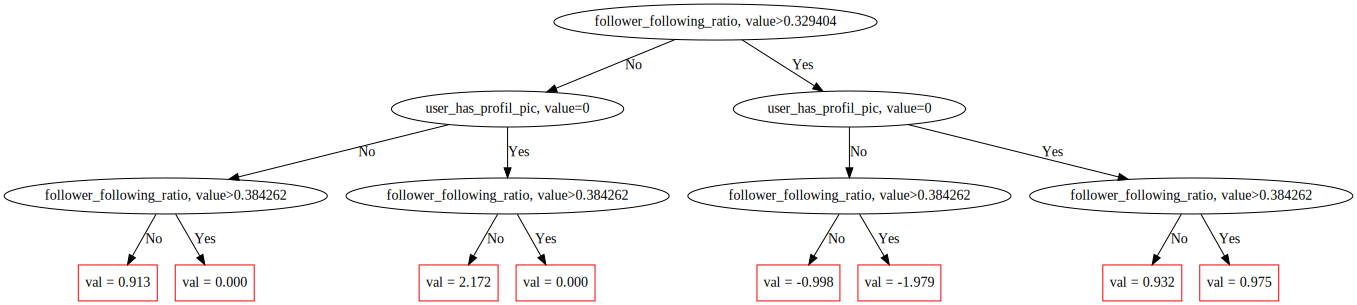

In [29]:
%%time

os.environ["PATH"] += os.pathsep + 'C:/Users/dell latitude/anaconda3/Library/bin/graphviz/'

pohon_params = params.copy()
pohon_params.update({
    'max_depth': 3
})

model4 = CatBoostClassifier(**pohon_params).fit(train4_pool, eval_set=validation4_pool, logging_level='Info')

# Visualisasi Pohon
model4.plot_tree(
    tree_idx=0,
    pool=train4_pool
)

In [30]:
print('Jumlah Pohon: {}'.format(model4.tree_count_))

Jumlah Pohon: 11


=== Confusion Matrix ===
[[194   6]
 [  7  32]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       200
           1       0.84      0.82      0.83        39

    accuracy                           0.95       239
   macro avg       0.90      0.90      0.90       239
weighted avg       0.95      0.95      0.95       239



Accuracy: 0.9456066945606695
F1_score: 0.8311688311688312
Recall_score: 0.8205128205128205
AUC_score: 0.8952564102564102
Sensitivity 0.8205128205128205
Specificity 0.97
Precision 0.8421052631578947


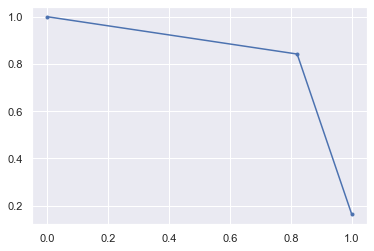

In [155]:
# Prediksi pada data test
model_predict=model4.predict(x_validation4)

print("=== Confusion Matrix ===")
print(confusion_matrix(y_validation4, model_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_validation4, model_predict))
print('\n')

# Akurasi Model

print("Accuracy:",metrics.accuracy_score(y_validation4, model_predict))
print("F1_score:",metrics.f1_score(y_validation4, model_predict))
print("Recall_score:",metrics.recall_score(y_validation4, model_predict))
print("AUC_score:",metrics.roc_auc_score(y_validation4, model_predict))
precision, recall, thresholds = metrics.precision_recall_curve(y_validation4, model_predict)

plt.plot(recall, precision, marker='.')

confusion = confusion_matrix(y_validation4, model_predict)

# True Positives
TP = confusion[1, 1]
# True Negatives
TN = confusion[0, 0]
# False Positives
FP = confusion[0, 1]
# False Negatives
FN = confusion[1, 0]
print("Sensitivity",TP / float(TP + FN))
print("Specificity",TN / float(TN + FP))
print("Precision",TP / float(TP + FP))

In [ ]:
# MEnampilkan metrik secara bersamaan

MetricVisualizer(['Model_1', 'Model_2','Model_3', 'Model_4']).start()

### 10) Menyimpan Model File JSON 

CatBoost juga mendukung ekspor model ke format JSON dan memuat model darinya.

In [31]:
# Save model JSON ke file

model4.save_model(
    'CatBoost_Model_Klasifikasi_Terbaik.json', 
    format='json',
    pool = train4_pool  # parameter ini diperlukan hanya untuk model dengan fitur kategoris.
)

In [32]:
# Memuat model dari file sebagai JSON dan menunjukkan keys. Model json berisi model_info, oblivious_trees dan features_info. 

model_json = json.load(open('CatBoost_Model_Klasifikasi_Terbaik.json', 'r'))
model_json.keys()

dict_keys(['features_info', 'model_info', 'oblivious_trees', 'scale_and_bias'])

In [33]:
# Melihat nilai features_info
# Ini bisa berisi 𝑓𝑙𝑜𝑎𝑡_𝑓𝑒𝑎𝑡𝑢𝑟𝑒𝑠, 𝑐𝑎𝑡𝑒𝑔𝑜𝑟𝑖𝑐𝑎𝑙_𝑓𝑒𝑎𝑡𝑢𝑟𝑒𝑠 dan 𝑐𝑡𝑟𝑠, yang merupakan daftar deskripsi dari beberapa fitur.

model_json['features_info'].keys()

dict_keys(['cat_features_hash', 'categorical_features', 'float_features'])

Melihat bagaimana model JSON mendeskripsikan satu pohon. Pohon dengan kedalaman $𝑘$ dideskripsikan dengan $2^𝑘$ leaf_values, $2^k$ leaf_ weights dan $𝑘$ splits

In [34]:
def dump_json(item):
    print(json.dumps(item, indent=2))

dump_json(model_json['oblivious_trees'][0])  # Pohon pertama dari model

{
  "leaf_values": [
    0.9125738526320859,
    0,
    2.1715098236136856,
    0,
    -0.9976738654156216,
    -1.9787685806394966,
    0.9317711486385005,
    0.9745656179970686
  ],
  "leaf_weights": [
    345,
    0,
    449,
    0,
    20,
    736,
    10,
    28
  ],
  "splits": [
    {
      "border": 0.38426172733306885,
      "float_feature_index": 0,
      "split_index": 5,
      "split_type": "FloatFeature"
    },
    {
      "cat_feature_index": 0,
      "split_index": 28,
      "split_type": "OneHotFeature",
      "value": -1438285038
    },
    {
      "border": 0.3294042646884918,
      "float_feature_index": 0,
      "split_index": 4,
      "split_type": "FloatFeature"
    }
  ]
}


- Daftar "leaf_values" menjelaskan nilai dalam daun. Ini adalah pohon dengan 4 daun, memiliki kedalaman 2, yang berarti memiliki dua split yang berbeda. Split pertama digunakan untuk membagi semua objek menjadi kiri dan kanan. Dan split kedua digunakan dua kali, untuk membagi objek kiri menjadi dua bagian, dan untuk membagi objek kanan menjadi dua bagian. Indeks dalam daftar dapat direpresentasikan menggunakan sistem angka basis-2 dengan cara berikut: 00, 01, 10, 11. Daun 00 adalah daun di mana split ke-0 dan split ke-1 sama dengan False. Daun 01 berisi objek di mana split ke-0 sama dengan False dan split ke-1 sama dengan True. Dan seterusnya.

- Bagian selanjutnya dari deskripsi pohon disebut "leaf_weights". Daftar ini mewakili jumlah bobot sampel pelatihan, yang ada di daun ini. Indeksasi daun dalam daftar ini sama dengan di "leaf_values".

- Bagian terakhir adalah "split", dan itu adalah deskripsi dari dua split yang digunakan pada pohon kedalaman dua. Setiap deskripsi berisi beberapa keys-values. Pertama, ini berisi parameter CatBoost internal $split\_index$. Ini adalah satu-satunya parameter yang digunakan oleh catboost saat memuat model, semua bagian lain dalam "splits" diabaikan (mereka digandakan di tempat yang berbeda), dan yang ada di sini hanya untuk membuat model lebih mudah dipahami.

In [173]:
dump_json(model_json['oblivious_trees'][1])  # Pohon kedua dari model

{
  "leaf_values": [
    1.2407543994654773,
    1.0832968780214958,
    0.4380417489178649,
    1.4839428809979258,
    1.8347665493671803,
    0.7944526451516157,
    0.3122187146690869,
    -1.0317454977798444,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1.0904384797037503,
    0.39692399989371147,
    1.2636877805949194,
    0.18091294619314738,
    1.124555475121854,
    0.39692399989371147,
    1.2013086213338362,
    -0.05589840679287392,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    -0.6284282045658032,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    -0.08949713826123419,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
  ],
  "leaf_weights": [
    31,
    21,
    13,
    7,
    131,
    10,
    141,
    726,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    61,
    8,
    43,
    1,
    175,
    8,
    169,
    22,
    0,
 

In [174]:
dump_json(model_json['oblivious_trees'][2])  # Pohon ketiga dari model

{
  "leaf_values": [
    0.20712051022083836,
    1.293786344129867,
    0.6311038477197584,
    0,
    0,
    0,
    0,
    0,
    0.46472246264528755,
    0.1642089326102569,
    0.5825040083929333,
    0.11056940093475952,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0.15009227204889986,
    0.32854410126262434,
    -0.14933391058838738,
    0,
    0,
    0,
    0,
    0.26936366244675464,
    0.5142930142827588,
    0.7178508002547226,
    0.012967471563623127,
    0,
    0,
    0,
    0,
    0,
    0,
    0.9011699072841115,
    -1.0129247149825162,
    0,
    0,
    0.035671066578999315,
    -1.0083110766510648,
    0,
    0,
    0.8646609570212926,
    0.11430092156691146,
    0,
    0,
    0,
    0
  ],
  "leaf_weights": [
    23,
    6,
    18,
    0,
    0,
    0,
    0,
    0,
    18,
    2,
    43,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
  

In [175]:
dump_json(model_json['oblivious_trees'][3])  # Pohon keempat dari model

{
  "leaf_values": [
    0.001165096846066533,
    0.6564185988492364,
    0.35892171131526934,
    -1.2969553896525685,
    0.18957122360305603,
    0.7853894229294254,
    -0.27279837616696756,
    -0.8523913711042693,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    -0.19309037569523693,
    0,
    0,
    -0.29946069634230715,
    -0.8601255707265729,
    0,
    0,
    -0.15412254428053904,
    -1.2429576353541676,
    0,
    0,
    0,
    -0.22491943872970108,
    0,
    0,
    0,
    -1.15888522203729,
    0,
    0,
    0.8178333790595013,
    0.5192257103652652,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1.2175262018885593,
    -0.5416913129052873,
    0,
    0,
    1.3079380529537943,
    0,
    0,
    0,
    0,
    0.07304391383100867,
    0,
    0,
    0,
    -0.026787565763043083
  ],
  "leaf_weights": [
    32,
    27,
    339,
    10,
    12,
    8,
    71,
    77,
    0,
    0,
    0,
    0,
    0,
    0,
    0

In [176]:
dump_json(model_json['oblivious_trees'][4])  # Pohon kelima (pohon terakhir) dari model

{
  "leaf_values": [
    0.22998133154991804,
    0,
    0.16825829635739134,
    0,
    0,
    0,
    0,
    0,
    0.021627129955279968,
    -0.14467706995064325,
    -0.45953055984032837,
    -0.1271084859060166,
    0,
    0,
    0,
    -0.010748782749256893,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0.15298125139379148,
    -0.7138746534711088,
    -0.11215463648170199,
    -0.4283125618717119,
    0,
    -0.18862166645968345,
    0,
    -0.1142096700017304,
    0.314075142366972,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    -0.09182146867042887,
    0,
    -0.07665173785918783,
    -0.0072008417290810875,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0.018470935342316395,
    -0.11036221164710955,
    0,
    -0.031072874374902654,
    0,
    0,
    0,
    -0.007233650308626271
  ],
  "leaf_weights": [
    54,
    0,
    3,
    0,
    0,
    0,
    0,
    0,
    128,
    7,
    15,
    10,
    0,
    0,
    0,
   

- Daftar "leaf_values" menjelaskan nilai dalam daun. Ini adalah pohon dengan 4 daun, memiliki kedalaman 2, yang berarti memiliki dua split yang berbeda. Split pertama digunakan untuk membagi semua objek menjadi kiri dan kanan. Dan split kedua digunakan dua kali, untuk membagi objek kiri menjadi dua bagian, dan untuk membagi objek kanan menjadi dua bagian. Indeks dalam daftar dapat direpresentasikan menggunakan sistem angka basis-2 dengan cara berikut: 00, 01, 10, 11. Daun 00 adalah daun di mana split ke-0 dan split ke-1 sama dengan False. Daun 01 berisi objek di mana split ke-0 sama dengan False dan split ke-1 sama dengan True. Dan seterusnya.

- Bagian selanjutnya dari deskripsi pohon disebut "leaf_weights". Daftar ini mewakili jumlah bobot sampel pelatihan, yang ada di daun ini. Indeksasi daun dalam daftar ini sama dengan di "leaf_values".

- Bagian terakhir adalah "split", dan itu adalah deskripsi dari dua split yang digunakan pada pohon kedalaman dua. Setiap deskripsi berisi beberapa keys-values. Pertama, ini berisi parameter CatBoost internal $split\_index$. Ini adalah satu-satunya parameter yang digunakan oleh catboost saat memuat model, semua bagian lain dalam "splits" diabaikan (mereka digandakan di tempat yang berbeda), dan yang ada di sini hanya untuk membuat model lebih mudah dipahami.